# BASELINE REINFORCE Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

# Instalación de librería gym

https://gym.openai.com/

pip install gym

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

# Cart Pole problem

![alt text](cart_pole.gif "Title")

In [14]:
env = gym.make("CartPole-v0")

![alt text](baseline_reinforce_algo.png "Title")

# Train full model

In [4]:
from reinforce_alg_helper import plot_episode, run_episode, score_model, get_observations_stats, get_random_episode, get_policy_model, get_batch_data, apply_baselines, actions_to_one_hot

Using TensorFlow backend.


In [5]:
# %time states_means, states_stds = get_observations_stats(env, get_random_episode, N=10000, plot_it=False)

In [6]:
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

In [7]:
def get_value_func_model(lr=0.001, neourons=128):
    model_value_func = Sequential()
    model_value_func.add(Dense(neourons, input_shape=[4], 
                               activation='relu',
                               #use_bias=False,
                               kernel_initializer=glorot_uniform(seed=42)
                              ))
    model_value_func.add(Dense(1,  
                         #use_bias=False,
                         kernel_initializer=glorot_uniform(seed=42)
                              )
                        )
    model_value_func.compile(Adam(lr), loss='mse')
    return model_value_func

In [8]:
def train_full_model(lr=0.1, max_num_episodes = 10000, episodes_batch_size = 50, training_epochs = 5, goal = 200, 
                     reset_model=True, hidden_layer_neurons = 128, verbose_period = 2, 
                     score_thres=10, states_means=None, states_stds=None,
                     model_train=None, model_predict=None):
    losses=[]
    if model_train is None:
        # Get model
        model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
    model_value_func = get_value_func_model(0.1, 128)
    num_episode = 0
    i = 0
    while num_episode < max_num_episodes:
        # Get batch_size episodes for training
        batch_states, batch_actions, discounted_rewards, batch_probs = get_batch_data(env, model_predict, episodes_batch_size)
        if states_means is not None:
            batch_states = (batch_states - states_means)/states_stds
        # format data for NN
        # mean = discounted_rewards.mean()
        # std = discounted_rewards.std()
        discounted_rewards_variance = discounted_rewards.var()
        discounted_rewards_normalized = discounted_rewards # (discounted_rewards - mean)/std
        hist = model_value_func.fit(batch_states, discounted_rewards_normalized, batch_size=len(batch_states), epochs=10, verbose=0)
        mse_loss = hist.history['loss']
        discounted_rewards_baseline = model_value_func.predict(batch_states, verbose=0).squeeze() # *std + mean
        actions_train = actions_to_one_hot(batch_actions)
        hist = model_train.fit([batch_states, discounted_rewards.squeeze() - discounted_rewards_baseline], actions_train,
                        epochs=training_epochs, batch_size=len(batch_states), verbose=0
                       )
        losses = losses + hist.history['loss']
          
        score = score_model(model_predict, env, score_thres)
        if (i%verbose_period) == 0:
            entropy = np.mean(-np.sum(np.log(batch_probs)*batch_probs, axis=1)/np.log(2))
            print(f'{num_episode}) loss: {losses[-1]:.2f}, (mean_VAR, Val_func, ratio): ({discounted_rewards_variance:.2f}, {mse_loss[0]:.2f}, {(mse_loss[0]/discounted_rewards_variance):.2f}), score: {score}, entropy: {entropy:.3f}')
        if score >= goal:
            print("Solved in {} episodes!".format(num_episode))
            break
        num_episode+=episodes_batch_size
        i+=1
    return losses, model_train, model_predict

In [9]:
losses, model_train, model_predict = train_full_model(lr=0.005, training_epochs = 1, hidden_layer_neurons = 128, 
                                                      episodes_batch_size = 1, max_num_episodes=10000, 
                                                      score_thres = 10, 
                                                      #states_means=states_means, states_stds=states_stds,
                                                      model_train=None, model_predict=None)
#                                                       model_train=model_train, model_predict=model_predict)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0) loss: -1.65, (mean_VAR, Val_func, ratio): (29.78, 135.36, 4.55), score: 9.2, entropy: 0.997
2) loss: -0.58, (mean_VAR, Val_func, ratio): (24.84, 43.51, 1.75), score: 50.4, entropy: 0.999
4) loss: -2.19, (mean_VAR, Val_func, ratio): (132.06, 238.20, 1.80), score: 14.2, entropy: 0.998
6) loss: -0.52, (mean_VAR, Val_func, ratio): (52.60, 140.96, 2.68), score: 18.9, entropy: 0.994
8) loss: 2.61, (mean_VAR, Val_func, ratio): (62.23, 218.80, 3.52), score: 13.4, entropy: 1.000
10) loss: 0.39, (mean_VAR, Val_func, ratio): (14.14, 30.29, 2.14), score: 11.7, entropy: 0.964
12) loss: -6.05, (mean_VAR, Val_func, ratio): (49.50, 295.44, 5.97), score: 68.6, entropy: 0.990
14) loss: -3.67, (mean_VAR, Val_func, ratio): (75.81, 218.17, 2.88), score: 68.7, entropy: 0.986
16) loss: -0.40, (mean_VAR, Val_func, ratio): (52.60, 62.61, 1.19), score: 106.3, entropy: 0.962
18) loss: -0.40,

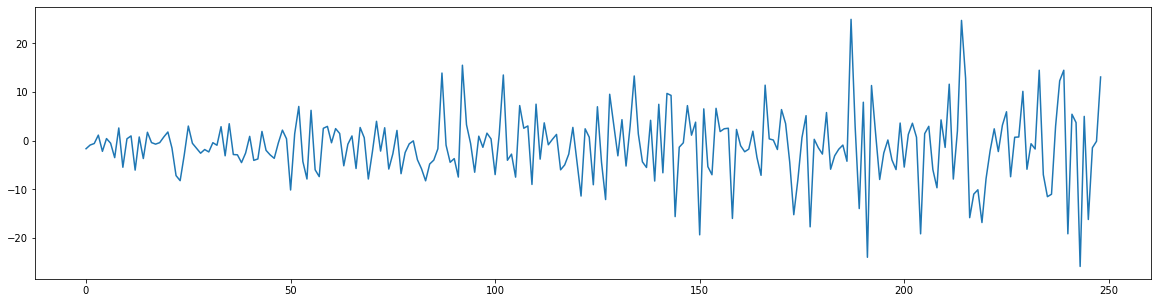

In [10]:
plt.figure(figsize=(20,5))
plt.plot(losses)

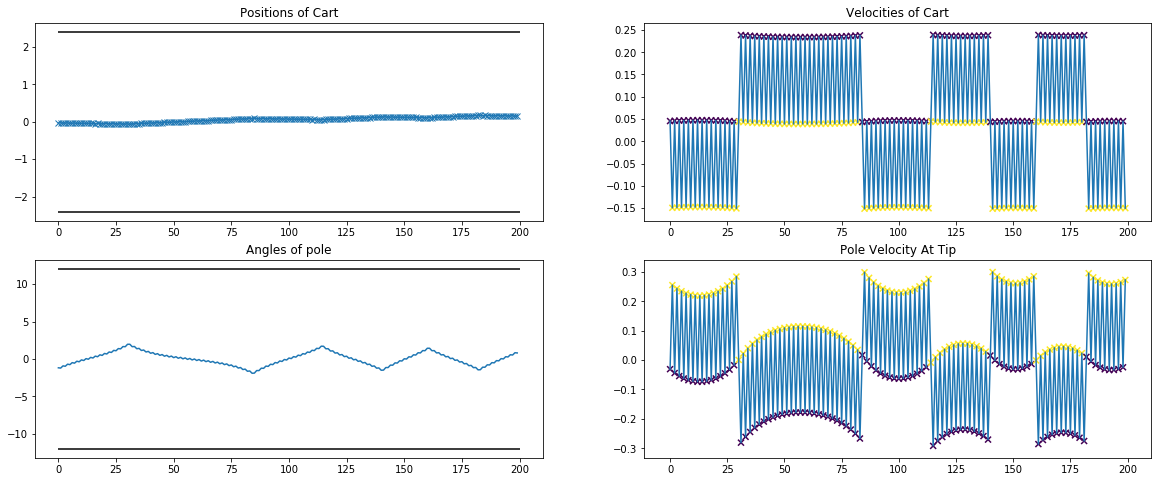

In [11]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model_predict, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

Media de las acciones [0,1]: 0.49902277485544605
Media de rewards: 172.427


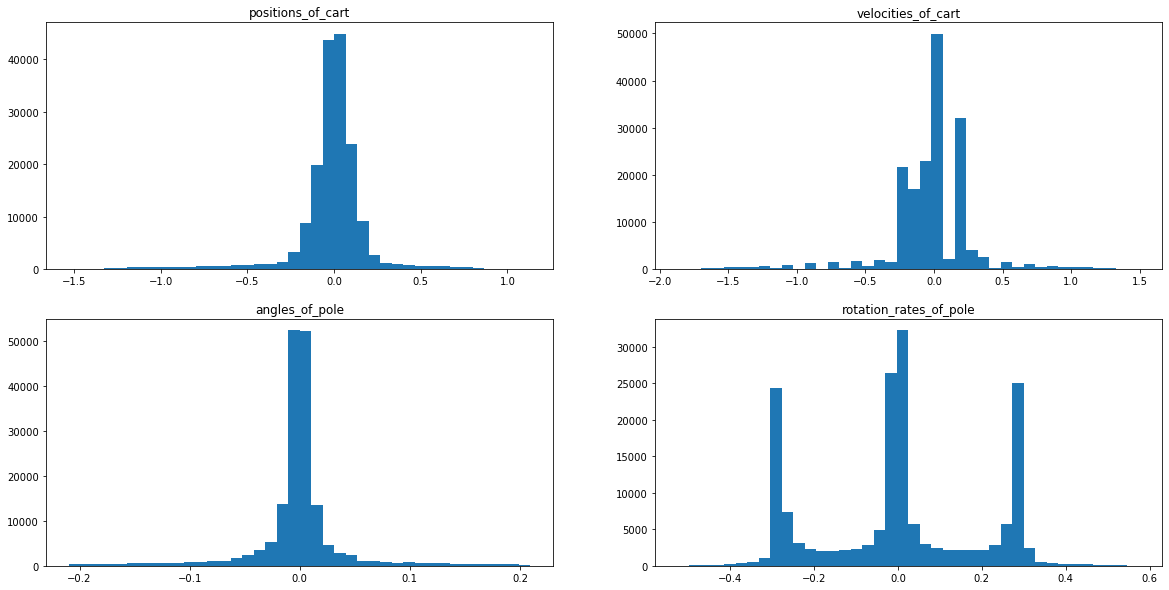

CPU times: user 1min 19s, sys: 4.78 s, total: 1min 23s
Wall time: 49.7 s


In [12]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=True), N=1000)

Media de las acciones [0,1]: 0.48576065996083717
Media de rewards: 134.311


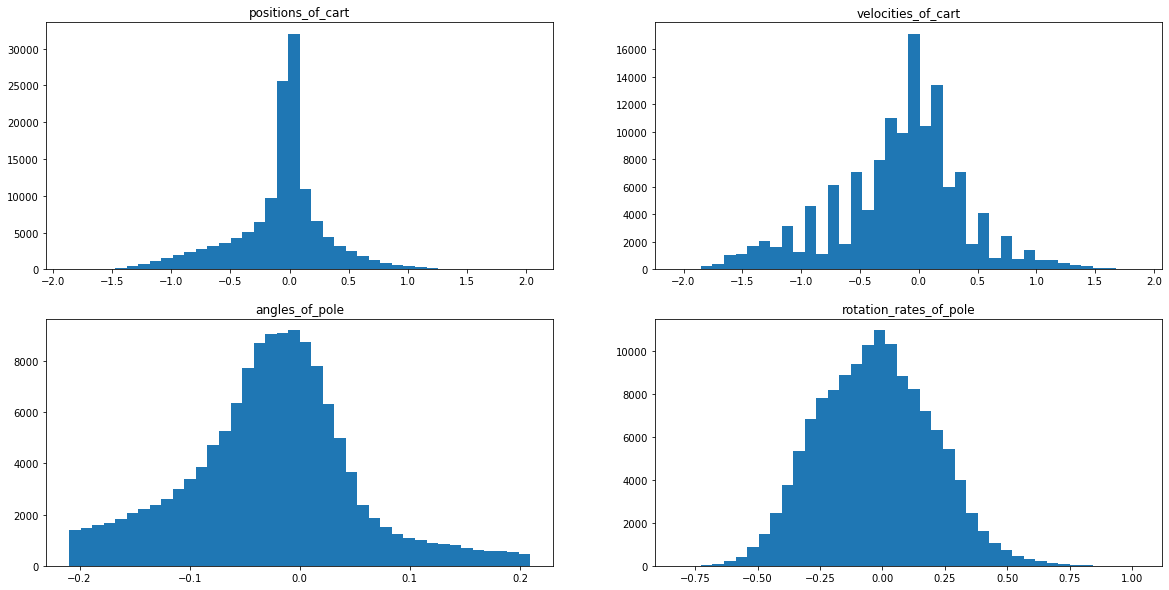

CPU times: user 1min 9s, sys: 3.66 s, total: 1min 13s
Wall time: 46.6 s


In [13]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=False), N=1000)

In [177]:
# model_predict.save('model_predict-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')
# model_train.save('model_train-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')

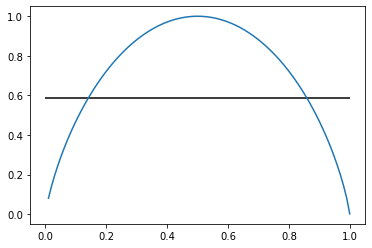

In [45]:
probs = np.linspace(0.01, 0.9999, 100)
plt.plot(probs, (probs*np.log(1/probs) + (1-probs)*np.log(1/(1-probs)))/np.log(2))
plt.hlines(0.586, 0, 1)